### Sample R code for AB testing

### Summary of the data 

In [1]:
data <- read.csv("abtest_example_ctr.csv")

In [2]:
summary(data)

     userid      country         groups         deviceid         device    
 Min.   : 1000   CA:4571   control  :11460   Min.   : 5000   Android:7003  
 1st Qu.: 3256   CN:4576   treatment:11500   1st Qu.: 8758   Ios    :4583  
 Median : 5450   GB:4631                     Median :12538   Other  :4717  
 Mean   : 5485   US:9182                     Mean   :12566   Web    :6657  
 3rd Qu.: 7717                               3rd Qu.:16409                 
 Max.   :10000                               Max.   :20000                 
 NA's   :275                                                               
    sellerid         itemid             date           views       
 Min.   :100.0   Min.   :1000   2017-05-16: 1721   Min.   : 0.000  
 1st Qu.:203.0   1st Qu.:1508   2017-05-15: 1701   1st Qu.: 4.000  
 Median :304.0   Median :1994   2017-05-13: 1674   Median : 6.000  
 Mean   :302.2   Mean   :1998   2017-05-09: 1657   Mean   : 5.796  
 3rd Qu.:402.0   3rd Qu.:2497   2017-05-11: 1650   3

### Data Cleaning

In [3]:
# check if there is na for user ID
sum(is.na(data$userid))/nrow(data) 

[1] 0.01197735

In [4]:
library(sqldf)

Loading required package: gsubfn
Loading required package: proto
Warning message in system2("/usr/bin/otool", c("-L", shQuote(DSO)), stdout = TRUE):
“running command ''/usr/bin/otool' -L '/Users/miaosun/opt/anaconda3/envs/r-tutorial/lib/R/library/tcltk/libs//tcltk.so'' had status 1”Loading required package: RSQLite


In [5]:
#check if people assigned to both test and group
sqldf("select count(1) from (select userid, count(distinct(groups)) 
      from data group by userid having count(distinct(groups)) >1) as a")


count(1)
44


In [ ]:
#check if the NA and mixed assignments are random 

In [6]:
Pb_miss=1*is.na(data$userid)

In [8]:
userid_mix=as.numeric(sqldf("select userid from (select userid, count(distinct(groups)) 
                  from data group by userid having count(distinct(groups)) >1) as a")[[1]])


In [12]:
fun_Pb_mix=function(x){x %in%userid_mix}

In [13]:
Pb_mix=1*sapply(data$userid,FUN=fun_Pb_mix)


In [14]:
data$pb_all = dd = apply(matrix(cbind(Pb_miss, Pb_mix), nrow = nrow(data)), 1, max)

In [15]:
head(data)

userid,country,groups,deviceid,device,sellerid,itemid,date,views,clicks,revenue,pb_all
3441,US,control,12745,Ios,306,1685,2017-05-09,5,1,0.0000,0
3048,GB,control,19244,Android,227,2257,2017-05-09,3,1,0.0000,0
6640,CA,treatment,17198,Other,220,2977,2017-05-10,8,2,114.0904,0
4326,US,control,5329,Ios,431,1471,2017-05-12,4,0,0.0000,0
6993,US,control,15955,Web,399,1812,2017-05-08,4,2,0.0000,0
3894,CN,control,10976,Ios,215,1759,2017-05-12,5,0,0.0000,0


In [16]:
pb_mod = glm(pb_all ~ country + groups + device + date + views + clicks + revenue, data, family = 'binomial')
summary(pb_mod)



Call:
glm(formula = pb_all ~ country + groups + device + date + views + 
    clicks + revenue, family = "binomial", data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.3327  -0.2099  -0.1859  -0.1648   3.0867  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -3.561125   0.259304 -13.733  < 2e-16 ***
countryCN       -0.553733   0.150337  -3.683 0.000230 ***
countryGB       -0.619374   0.153028  -4.047 5.18e-05 ***
countryUS       -0.419895   0.121147  -3.466 0.000528 ***
groupstreatment -0.233533   0.098624  -2.368 0.017889 *  
deviceIos       -0.353405   0.155658  -2.270 0.023184 *  
deviceOther     -0.095581   0.142322  -0.672 0.501848    
deviceWeb        0.194276   0.120892   1.607 0.108048    
date2017-05-09  -0.144084   0.286270  -0.503 0.614744    
date2017-05-10   0.017315   0.275703   0.063 0.949923    
date2017-05-11   0.217898   0.264204   0.825 0.409523    
date2017-05-12   0.225483   0.263309   0.856 

In [17]:
#the result shows that some countries and devices have significant results. Need dive 
#into the data to see if there is any bug

In [18]:
aggregate(Pb_miss, by = list(data$device), FUN = mean)

Group.1,x
Android,0.013708411
Ios,0.008946105
Other,0.009751961
Web,0.013820039


In [19]:
aggregate(Pb_mix, by = list(data$device), FUN = mean)

Group.1,x
Android,0.01870627
Ios,0.01352826
Other,0.01738393
Web,0.02268289


In [20]:
aggregate(Pb_miss, by = list(data$country), FUN = mean)

Group.1,x
CA,0.01268869
CN,0.01245629
GB,0.01014900
US,0.01230669


In [21]:
aggregate(Pb_mix, by = list(data$country), FUN = mean)

Group.1,x
CA,0.02669000
CN,0.01573427
GB,0.01468365
US,0.01786103


In [22]:
##Android and Web have more problematic user ids. CA has more problematic user ids.

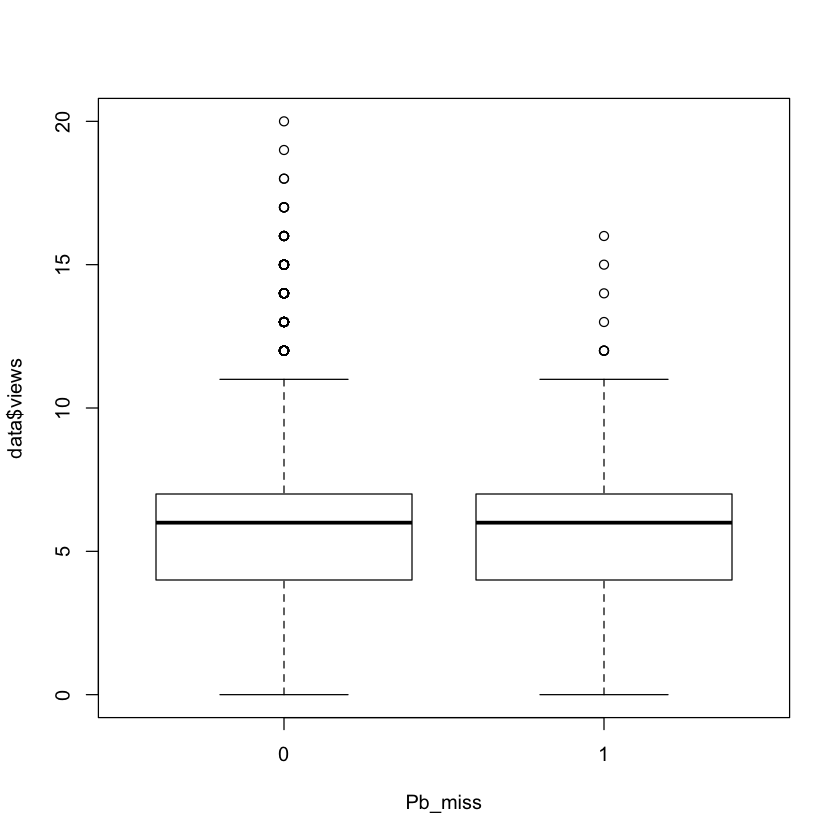

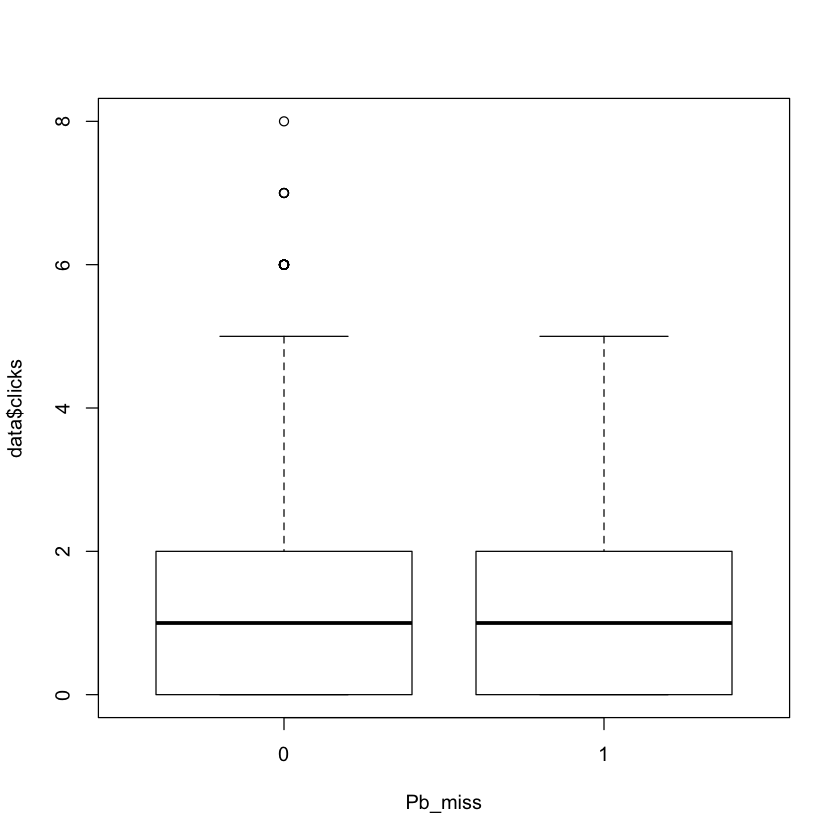

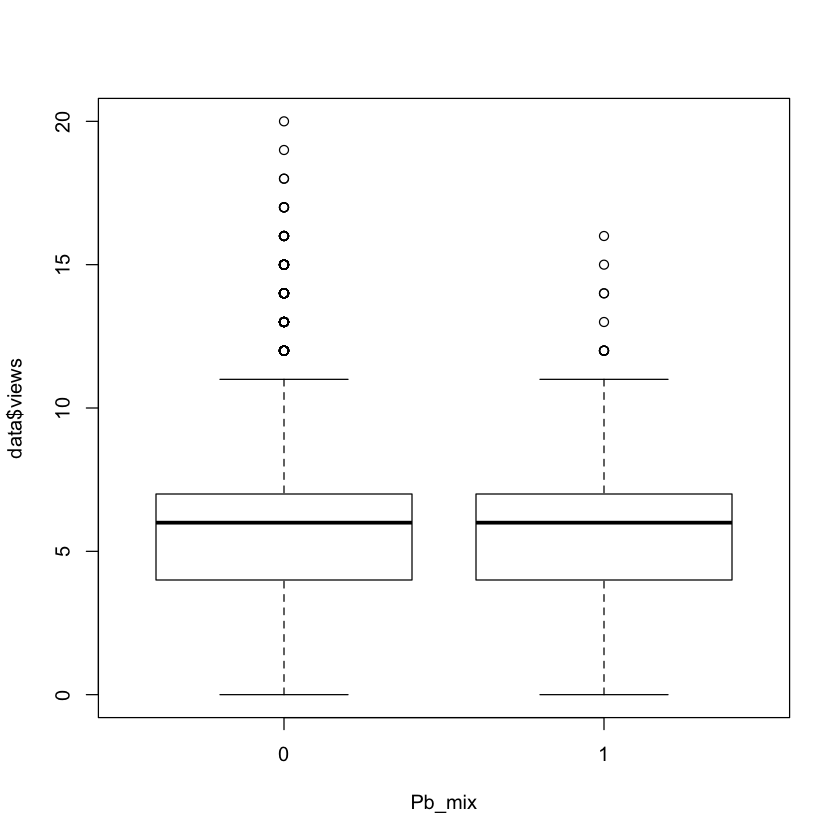

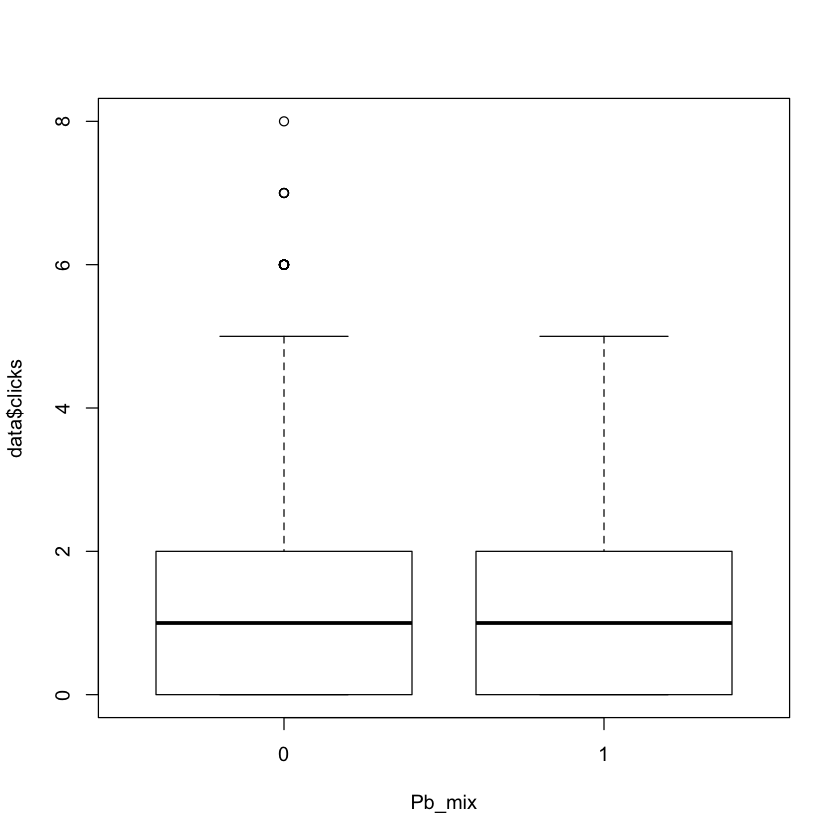

In [23]:
# blox of key metrics, views, clicks, ctr, problem
boxplot(data$views~Pb_miss)
boxplot(data$clicks~Pb_miss)

boxplot(data$views~Pb_mix)
boxplot(data$clicks~Pb_mix)


In [24]:
# For simplicity, throw away the problematic assignments
data=data[data$pb_all == 0,]

In [26]:
# sanity check, check before experiment, metrics are comparable, no sig diff between test/control
# day1-day3 data was before experiment start

In [27]:
data$date=as.Date(data$date)
data_before<-data[data$date<(min(data$date)+3),]
data_start<-data[data$date>=(min(data$date)+3),]

In [29]:
#compare aggregated CTR between control and test 
x1=sum(data_before$clicks[data_before$groups=='treatment'])
x2=sum(data_before$clicks[data_before$groups=='control'])
n1=sum(data_before$views[data_before$groups=='treatment'])
n2=sum(data_before$views[data_before$groups=='control'])
prop.test(x=c(x1,x2),n=c(n1,n2),alternative = 'two.sided')


	2-sample test for equality of proportions with continuity correction

data:  c(x1, x2) out of c(n1, n2)
X-squared = 0.17521, df = 1, p-value = 0.6755
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.007714841  0.012063071
sample estimates:
   prop 1    prop 2 
0.1987792 0.1966050 


In [30]:
# by subgroup, write a function, apply, which signficant
ztest_by_subgroup<-function(data_start, bycol, val)
{
  data_use=data_start[data_start[bycol]==val,]
  x1=sum(data_use$clicks[data_use$groups=='treatment'])
  x2=sum(data_use$clicks[data_use$groups=='control'])
  n1=sum(data_use$views[data_use$groups=='treatment'])
  n2=sum(data_use$views[data_use$groups=='control'])
  return(prop.test(x=c(x1,x2),n=c(n1,n2),alternative = 'two.sided'))
}

In [31]:
test_bydevice = data.frame(matrix(nrow = 0, ncol = 6,
                          dimnames = list(NULL, 
                                          c('device','p.value','ctr_treatment',
                                            'ctr_control', 'ci.low','ci.high'))))

In [32]:
for (i in 1:length(unique(data$device))){
  device = as.character(unique(data$device)[i])
  test = ztest_by_subgroup(data_start, 'device', device)
  # you can check available statistics using names(test)
  testresult = data.frame('device' = device, 
                          'p.value' = test$p.value, 
                          'ctr_treatment' = test$estimate[1], 
                          'ctr_control' = test$estimate[2],
                          'ci.low' = test$conf.int[1],
                          'ci.high' = test$conf.int[2])
  test_bydevice = rbind(test_bydevice,testresult)
}


In [33]:
test_bydevice


,device,p.value,ctr_treatment,ctr_control,ci.low,ci.high
prop 1,Ios,0.0003132683,0.2248439,0.2043355,0.009299978,0.031716743
prop 11,Android,0.2485651262,0.1993677,0.2046524,-0.014220745,0.003651285
prop 12,Other,0.6471968148,0.2026693,0.2000920,-0.008159109,0.013313813
prop 13,Web,0.4594004175,0.2030591,0.1996187,-0.005568058,0.012448832


In [34]:
# Ios significant, figure out why only works for Ios. Discuss with Eng & PM

### Revenue analysis

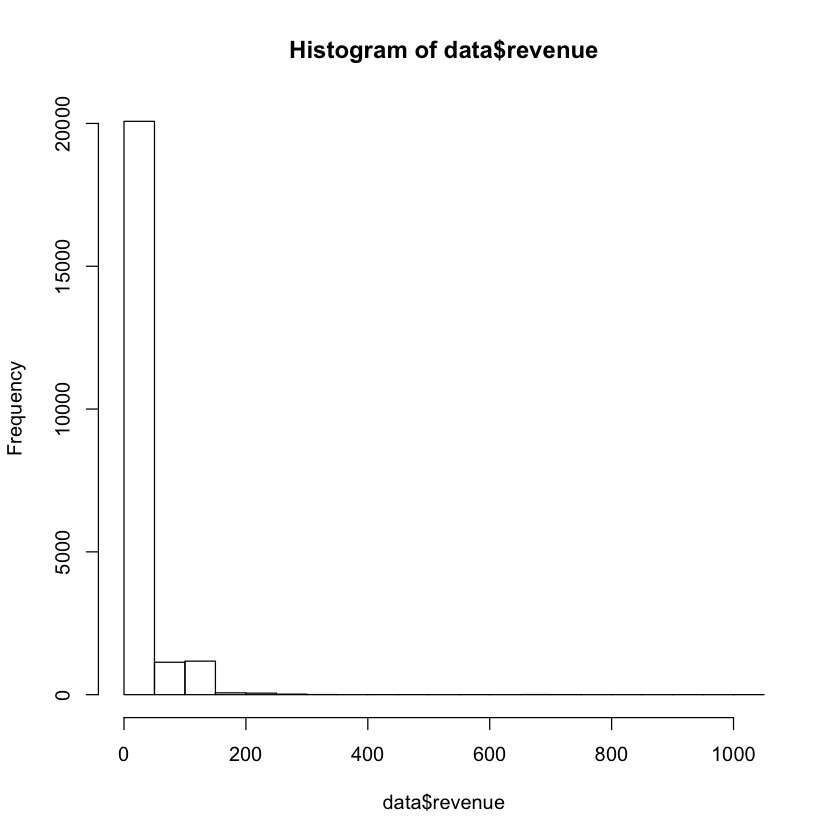

In [35]:
hist(data$revenue)

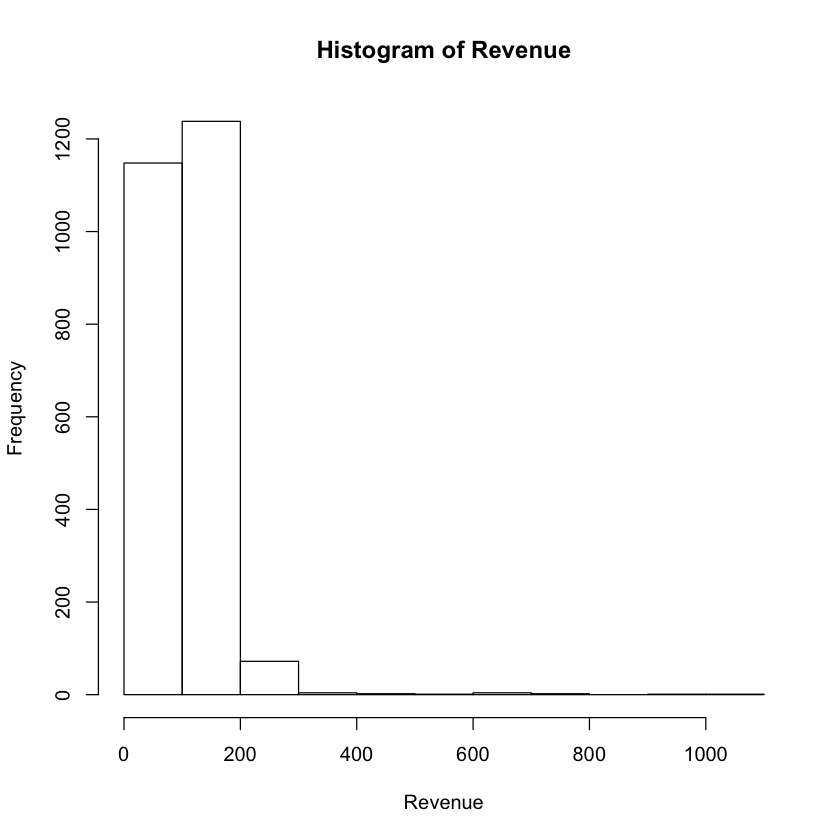

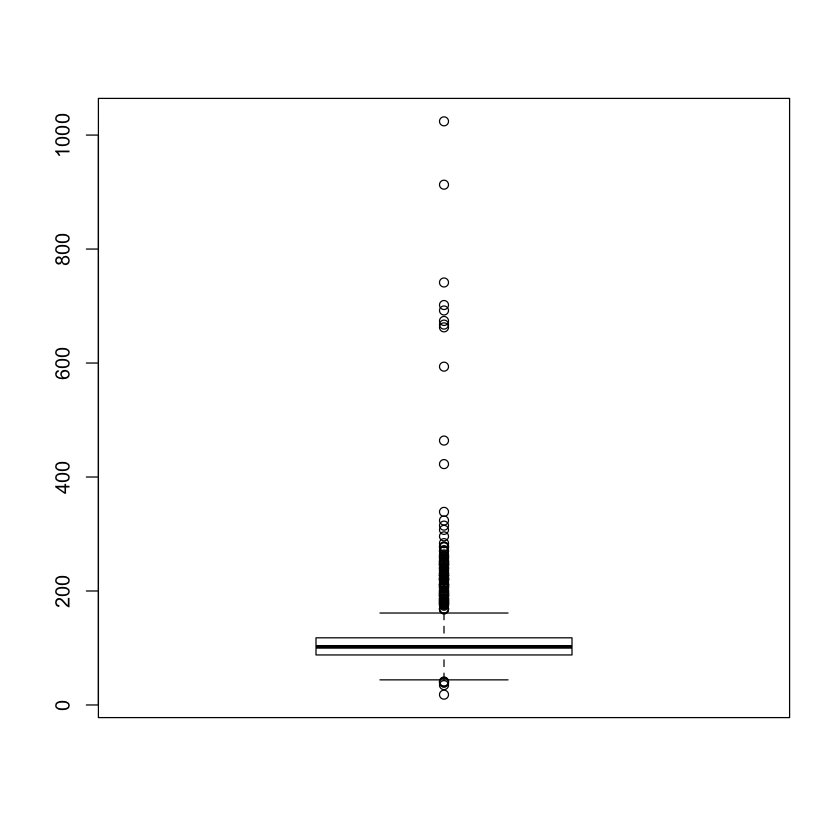

In [37]:
#only consider revenue with revenue>0
Revenue<-data$revenue[data$revenue>0]
hist(Revenue)
boxplot(Revenue)


In [38]:
True=mean(Revenue)

In [44]:
# compare normal(CLT) & bootstrap distribution for estimator
#CLT
E_mean=mean(Revenue)
E_var=var(Revenue)/length(Revenue)

In [45]:
E_mean
E_var

[1] 109.0289

[1] 1.095716

In [41]:
btsample = rep(0, 1000)
for (i in 1:1000){
  sample = Revenue[sample(length(Revenue), length(Revenue), replace =TRUE)]
  btsample[i] = mean(sample)
}
var_bt = var(btsample)

In [46]:
E_var 
var_bt

[1] 1.095716

[1] 1.081555

In [47]:
### Result Analysis

In [48]:
bound=quantile(Revenue,0.999)
data_before$revenue_win = ifelse(data_before$revenue>bound, bound, data_before$revenue)
data_start$revenue_win = ifelse(data_start$revenue>bound, bound, data_start$revenue)

In [49]:
head(data_before)

,userid,country,groups,deviceid,device,sellerid,itemid,date,views,clicks,revenue,pb_all,revenue_win
1,3441,US,control,12745,Ios,306,1685,2017-05-09,5,1,0.0000,0,0.0000
2,3048,GB,control,19244,Android,227,2257,2017-05-09,3,1,0.0000,0,0.0000
3,6640,CA,treatment,17198,Other,220,2977,2017-05-10,8,2,114.0904,0,114.0904
5,6993,US,control,15955,Web,399,1812,2017-05-08,4,2,0.0000,0,0.0000
10,4008,US,treatment,15139,Web,361,1673,2017-05-10,3,0,0.0000,0,0.0000
14,6053,GB,treatment,11927,Ios,350,2671,2017-05-10,6,0,0.0000,0,0.0000


In [50]:
# regular t.test
x1=data_start$revenue_win[data_start$groups=='treatment']
x2=data_start$revenue_win[data_start$groups=='control']
t.test(x = x1, y = x2,alternative = 'two.sided')


	Welch Two Sample t-test

data:  x1 and x2
t = -1.7091, df = 17678, p-value = 0.08746
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.0956885  0.1433807
sample estimates:
mean of x mean of y 
 11.86280  12.83896 


### Cohort Analysis

In [52]:
d4 = data_start[data_start$userid %in% data_start[data_start$date == "2017-05-11", 'userid'],]

In [53]:
test_bydate = data.frame(matrix(nrow = 0, ncol = 6,
dimnames = list(NULL, 
c('date','p.value','ctr_treatment',
'ctr_control', 'ci.low','ci.high'))))

In [57]:
test = ztest_by_subgroup(d4, 'date', date)

In [58]:
test


	2-sample test for equality of proportions with continuity correction

data:  c(x1, x2) out of c(n1, n2)
X-squared = 0.054752, df = 1, p-value = 0.815
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.04835466  0.03591267
sample estimates:
  prop 1   prop 2 
0.197031 0.203252 


In [54]:
for (i in 1:(length(unique(data$date))-3)){
  date = as.character(sort(unique(data$date))[i+3])
  test = ztest_by_subgroup(d4, 'date', date)
  # you can check available statistics using names(test)
  testresult = data.frame('date' = date, 
                          'p.value' = test$p.value, 
                          'ctr_treatment' = test$estimate[1], 
                          'ctr_control' = test$estimate[2],
                          'ci.low' = test$conf.int[1],
                          'ci.high' = test$conf.int[2])
  test_bydate = rbind(test_bydate,testresult)
}

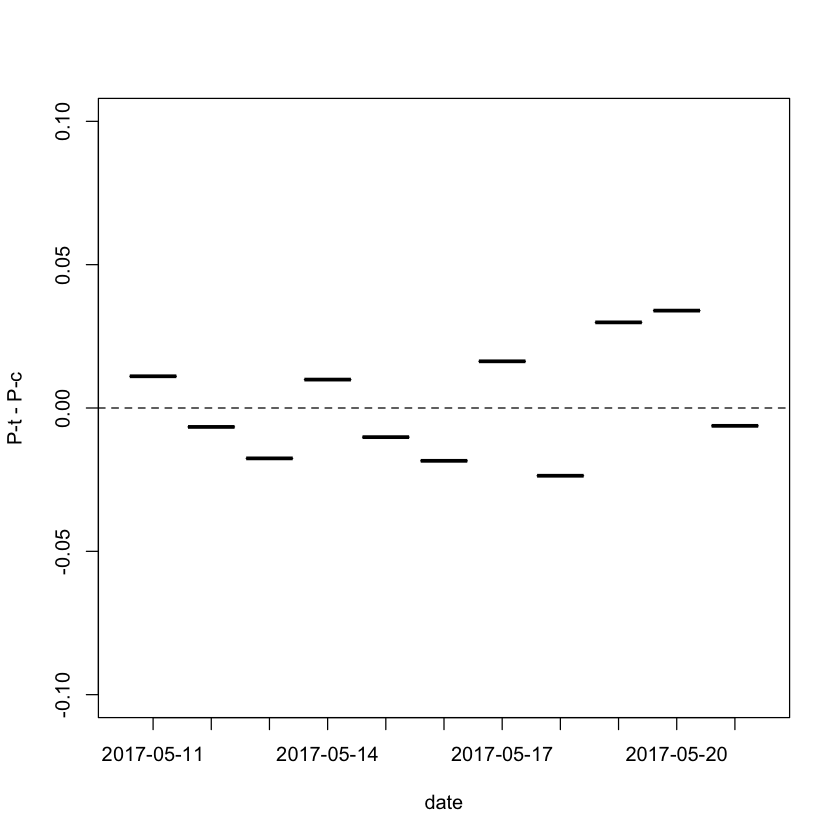

In [56]:
par(mfrow = c(1,1))
plot(ctr_treatment - ctr_control ~ date, data = test_bydate, ylim = c(-0.1, 0.1), ylab = 'P-t - P-c')
abline(h = 0, lty = 2)